# Part 1. Finetuning&Transfer Learning

**Original notebook**: [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

--2025-10-07 17:04:55--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.244.65, 52.222.244.25, 52.222.244.46, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.244.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   115MB/s    in 0.4s    

2025-10-07 17:04:55 (115 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data

In [3]:
len(os.listdir('hymenoptera_data/train/ants')), len(os.listdir('hymenoptera_data/train/bees'))

(124, 121)

In [4]:
len(os.listdir('hymenoptera_data/val/ants')), len(os.listdir('hymenoptera_data/val/bees'))

(70, 83)

In [5]:
datasets.ImageFolder??

In [8]:
transforms.ToTensor??

In [ ]:
(x - mean) / std

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


device(type='cuda', index=0)

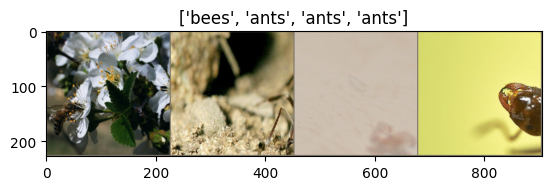

In [10]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
dataset_sizes

{'train': 244, 'val': 153}

In [12]:
from IPython.display import clear_output

### Train loop

In [14]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    best_acc = 0.0
    best_model_params_path = 'best_model'

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(inputs) # (B, 2)
                    preds = logits.argmax(dim=1)
                    loss = criterion(logits, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.cpu())

            print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_params_path = f'best_model_{epoch}.pth'
                torch.save(model.state_dict(), best_model_params_path)

            clear_output(True)
            plt.subplot(1, 2, 1)
            plt.plot(train_loss, label='train loss')
            plt.plot(val_loss, label='val loss')
            plt.legend()
            plt.subplot(1, 2, 2)
            plt.plot(train_acc, label='train acc')
            plt.plot(val_acc, label='val acc')
            plt.legend()
            plt.show()

    print(f'best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model

In [13]:
nn.CrossEntropyLoss??

## Part 1.1. Finetuning

In [15]:
model = models.resnet18(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
for param in model.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


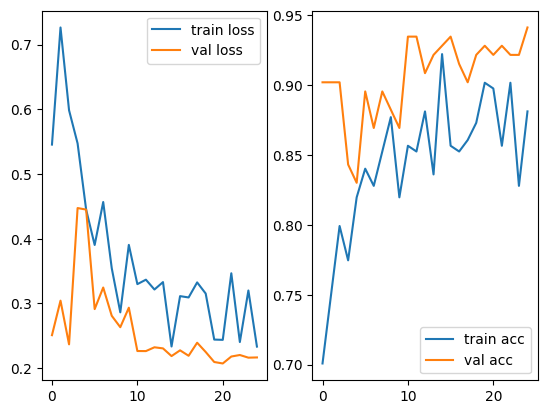

best val acc: 0.941176


In [18]:
model_trained = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [20]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                # ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

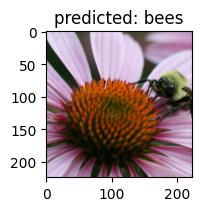

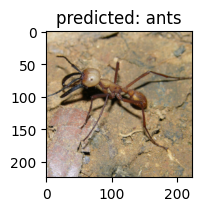

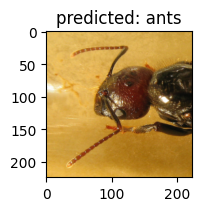

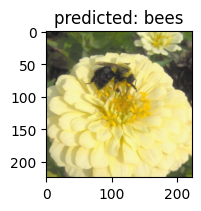

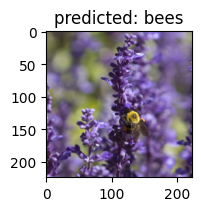

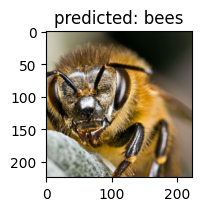

In [21]:
visualize_model(model)

## Part 1.2. Transfer Learning

In [23]:
model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

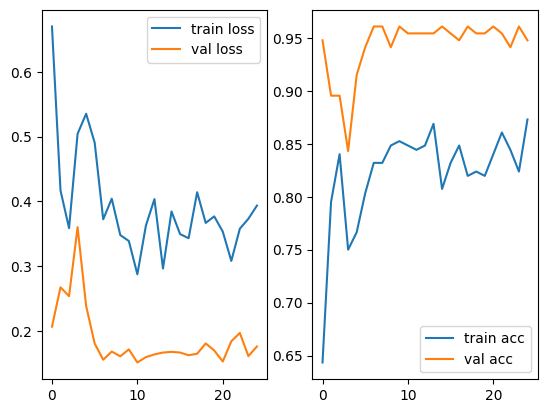

best val acc: 0.960784


In [24]:
model_trained = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Part 4. LR shedulers

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_model_lr(model, criterion, optimizer, scheduler=None, num_epochs=25):
    best_acc = 0.0
    best_model_params_path = 'best_model'

    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    lrs = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).cpu()

            lrs.append(get_lr(optimizer))
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print(f'{phase} loss: {epoch_loss:.4f} acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_params_path = f'best_model_{epoch}.pth'
                torch.save(model.state_dict(), best_model_params_path)

            clear_output(True)
            plt.subplot(1, 3, 1)
            plt.plot(train_loss, label='train loss')
            plt.plot(val_loss, label='val loss')
            plt.legend()
            plt.subplot(1, 3, 2)
            plt.plot(train_acc, label='train acc')
            plt.plot(val_acc, label='val acc')
            plt.legend()
            plt.subplot(1, 3, 3)
            plt.plot(lrs, label='lrs')
            plt.legend()

            plt.show()

    # print(f'best val acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

    return model

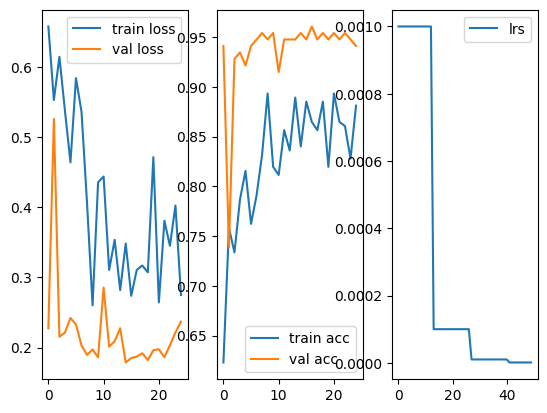

In [26]:
model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_trained = train_model_lr(model, criterion, optimizer_ft, scheduler, num_epochs=25)

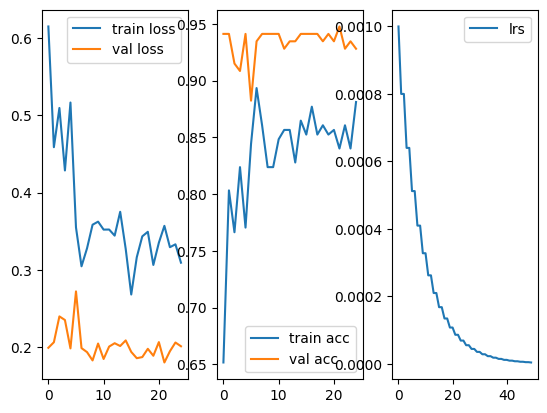

In [27]:
model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.8)

model_trained = train_model_lr(model, criterion, optimizer_ft, scheduler, num_epochs=25)

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=50)

model_trained = train_model_lr(model, criterion, optimizer_ft, scheduler, num_epochs=25)

# Part 2. Knowledge Distillation Tutorial

Author: Alexandros Chariton
**Original notebook**: [here](https://pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html)

## Loading CIFAR-10


CIFAR-10 is a popular image dataset with ten classes. Our objective is
to predict one of the following classes for each input image.

![Example of CIFAR-10
images](https://pytorch.org/tutorials//../_static/img/cifar10.png){.align-center}

The input images are RGB, so they have 3 channels and are 32x32 pixels.
Basically, each image is described by 3 x 32 x 32 = 3072 numbers ranging
from 0 to 255. A common practice in neural networks is to normalize the
input, which is done for multiple reasons, including avoiding saturation
in commonly used activation functions and increasing numerical
stability. Our normalization process consists of subtracting the mean
and dividing by the standard deviation along each channel. The tensors
\"mean=\[0.485, 0.456, 0.406\]\" and \"std=\[0.229, 0.224, 0.225\]\"
were already computed, and they represent the mean and standard
deviation of each channel in the predefined subset of CIFAR-10 intended
to be the training set. Notice how we use these values for the test set
as well, without recomputing the mean and standard deviation from
scratch. This is because the network was trained on features produced by
subtracting and dividing the numbers above, and we want to maintain
consistency. Furthermore, in real life, we would not be able to compute
the mean and standard deviation of the test set since, under our
assumptions, this data would not be accessible at that point.

As a closing point, we often refer to this held-out set as the
validation set, and we use a separate set, called the test set, after
optimizing a model\'s performance on the validation set. This is done to
avoid selecting a model based on the greedy and biased optimization of a
single metric.


In [28]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


In [29]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

## Defining model classes and utility functions

Next, we need to define our model classes. Several user-defined
parameters need to be set here. We use two different architectures,
keeping the number of filters fixed across our experiments to ensure
fair comparisons. Both architectures are Convolutional Neural Networks
(CNNs) with a different number of convolutional layers that serve as
feature extractors, followed by a classifier with 10 classes. The number
of filters and neurons is smaller for the students.


In [30]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

We employ 2 functions to help us produce and evaluate the results on our
original classification task. One function is called `train` and takes
the following arguments:

-   `model`: A model instance to train (update its weights) via this
    function.
-   `train_loader`: We defined our `train_loader` above, and its job is
    to feed the data into the model.
-   `epochs`: How many times we loop over the dataset.
-   `learning_rate`: The learning rate determines how large our steps
    towards convergence should be. Too large or too small steps can be
    detrimental.
-   `device`: Determines the device to run the workload on. Can be
    either CPU or GPU depending on availability.

Our test function is similar, but it will be invoked with `test_loader`
to load images from the test set.

![Train both networks with Cross-Entropy. The student will be used as a
baseline:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/ce_only.png){.align-center}


In [31]:
def train(model, train_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

## Cross-entropy runs


For reproducibility, we need to set the torch manual seed. We train
networks using different methods, so to compare them fairly, it makes
sense to initialize the networks with the same weights. Start by
training the teacher network using cross-entropy:


In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

100%|██████████| 391/391 [00:13<00:00, 28.24it/s]


Epoch 1/10, Loss: 1.3279037259118942


100%|██████████| 391/391 [00:13<00:00, 29.66it/s]


Epoch 2/10, Loss: 0.8708727868926495


100%|██████████| 391/391 [00:12<00:00, 30.18it/s]


Epoch 3/10, Loss: 0.6803775897721196


100%|██████████| 391/391 [00:12<00:00, 30.32it/s]


Epoch 4/10, Loss: 0.5333563172451371


100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


Epoch 5/10, Loss: 0.4108521027104629


100%|██████████| 391/391 [00:12<00:00, 30.13it/s]


Epoch 6/10, Loss: 0.30703100066660616


100%|██████████| 391/391 [00:12<00:00, 30.26it/s]


Epoch 7/10, Loss: 0.21853572658032103


100%|██████████| 391/391 [00:13<00:00, 29.75it/s]


Epoch 8/10, Loss: 0.16956328493935982


100%|██████████| 391/391 [00:12<00:00, 30.72it/s]


Epoch 9/10, Loss: 0.14105842688390055


100%|██████████| 391/391 [00:13<00:00, 29.42it/s]

Epoch 10/10, Loss: 0.11476075627348002


Test Accuracy: 75.19%


In [34]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

In [42]:
# Instantiate the same lightweight network:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

assert torch.norm(nn_light.features[0].weight).item() == torch.norm(new_nn_light.features[0].weight).item()

AssertionError: 

In [36]:
train(nn_light, train_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

100%|██████████| 391/391 [00:11<00:00, 33.91it/s]


Epoch 1/10, Loss: 1.4701556519169332


100%|██████████| 391/391 [00:14<00:00, 27.88it/s]


Epoch 2/10, Loss: 1.1549578100214224


100%|██████████| 391/391 [00:11<00:00, 33.80it/s]


Epoch 3/10, Loss: 1.0184118621184697


100%|██████████| 391/391 [00:11<00:00, 33.28it/s]


Epoch 4/10, Loss: 0.9159538684903509


100%|██████████| 391/391 [00:11<00:00, 33.05it/s]


Epoch 5/10, Loss: 0.8400157462910313


100%|██████████| 391/391 [00:11<00:00, 32.83it/s]


Epoch 6/10, Loss: 0.7775888055791635


100%|██████████| 391/391 [00:11<00:00, 33.04it/s]


Epoch 7/10, Loss: 0.7129323982521701


100%|██████████| 391/391 [00:12<00:00, 32.55it/s]


Epoch 8/10, Loss: 0.6551238824339474


100%|██████████| 391/391 [00:11<00:00, 33.23it/s]


Epoch 9/10, Loss: 0.6028028395779602


100%|██████████| 391/391 [00:11<00:00, 33.70it/s]

Epoch 10/10, Loss: 0.552874663220647


Test Accuracy: 70.96%


In [37]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 75.19%
Student accuracy: 70.96%


## Knowledge distillation run

Now let\'s try to improve the test accuracy of the student network by
incorporating the teacher. Knowledge distillation is a straightforward
technique to achieve this, based on the fact that both networks output a
probability distribution over our classes. Therefore, the two networks
share the same number of output neurons. The method works by
incorporating an additional loss into the traditional cross entropy
loss, which is based on the softmax output of the teacher network. The
assumption is that the output activations of a properly trained teacher
network carry additional information that can be leveraged by a student
network during training. The original work suggests that utilizing
ratios of smaller probabilities in the soft targets can help achieve the
underlying objective of deep neural networks, which is to create a
similarity structure over the data where similar objects are mapped
closer together. For example, in CIFAR-10, a truck could be mistaken for
an automobile or airplane, if its wheels are present, but it is less
likely to be mistaken for a dog. Therefore, it makes sense to assume
that valuable information resides not only in the top prediction of a
properly trained model but in the entire output distribution. However,
cross entropy alone does not sufficiently exploit this information as
the activations for non-predicted classes tend to be so small that
propagated gradients do not meaningfully change the weights to construct
this desirable vector space.

As we continue defining our first helper function that introduces a
teacher-student dynamic, we need to include a few extra parameters:

-   `T`: Temperature controls the smoothness of the output
    distributions. Larger `T` leads to smoother distributions, thus
    smaller probabilities get a larger boost.
-   `soft_target_loss_weight`: A weight assigned to the extra objective
    we\'re about to include.
-   `ce_loss_weight`: A weight assigned to cross-entropy. Tuning these
    weights pushes the network towards optimizing for either objective.

![Distillation loss is calculated from the logits of the networks. It
only returns gradients to the
student:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/distillation_output_loss.png){.align-center}


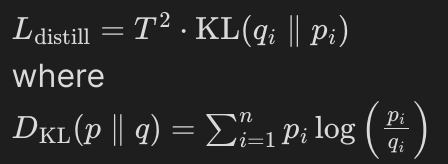

In [40]:
nn.CrossEntropyLoss??

In [43]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [44]:
# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(
    teacher=nn_deep,
    student=new_nn_light,
    train_loader=train_loader,
    epochs=10,
    learning_rate=0.001,
    T=2,
    soft_target_loss_weight=0.1,
    ce_loss_weight=0.9,
    device=device
)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

Epoch 1/10, Loss: 1.8426480043269788
Epoch 2/10, Loss: 1.4604723904748707
Epoch 3/10, Loss: 1.2949023301644094
Epoch 4/10, Loss: 1.165904606242314
Epoch 5/10, Loss: 1.0681363620111703
Epoch 6/10, Loss: 0.9842953457856727
Epoch 7/10, Loss: 0.9035806980584283
Epoch 8/10, Loss: 0.8280128143022737
Epoch 9/10, Loss: 0.7610281969580199
Epoch 10/10, Loss: 0.7046612646726086
Test Accuracy: 70.42%


In [45]:
# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Teacher accuracy: 75.19%
Student accuracy without teacher: 70.96%
Student accuracy with CE + KD: 70.42%


# Part 3. TensorRT

In [ ]:
!git clone https://github.com/NVIDIA-AI-IOT/torch2trt
cd torch2trt
python setup.py install

Cloning into 'torch2trt'...
remote: Enumerating objects: 4452, done.
remote: Counting objects: 100% (763/763), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 4452 (delta 647), reused 622 (delta 605), pack-reused 3689 (from 1)
Receiving objects: 100% (4452/4452), 7.77 MiB | 28.60 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.


In [ ]:
pip install torchvision

In [ ]:
import torch
import torchvision
from torch2trt import torch2trt

/content/torch2trt/torch2trt/dataset.py:61: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(self) > 0, 'Cannot create default flattener without input data.')


In [ ]:
model = torchvision.models.resnet50(pretrained=True).eval().cuda()

# create example data
x = torch.ones((1, 3, 224, 224)).cuda()

# convert to TensorRT feeding sample data as input
model_trt = torch2trt(model, [x])

# Part 5. Deep models interpretability
This notebooks shows examples of approaches for interpretation of (pre-)trained model predictions.

In [ ]:
import torch
import torch.nn as nn

In [ ]:
try:
    import skimage
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'scikit-image'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import skimage

In [ ]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models

import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

device: cuda


In [ ]:
# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [ ]:
class_labels[897]

'washer'

### Manual explanation with smoothgrad

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [ ]:
# model = torchvision.models.densenet121(pretrained=True).train(False).to(device)
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 51.5MB/s]


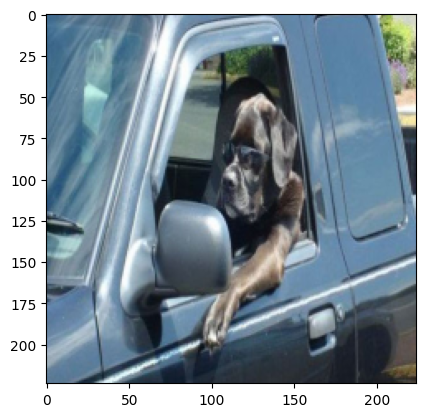

#1: p=0.853	bloodhound (163)
#2: p=0.039	washer (897)
#3: p=0.009	car_mirror (475)
#4: p=0.008	pickup (717)
#5: p=0.008	Weimaraner (178)
#6: p=0.007	Labrador_retriever (208)
#7: p=0.006	Chesapeake_Bay_retriever (209)
#8: p=0.005	limousine (627)
#9: p=0.004	pug (254)
#10: p=0.003	tub (876)


In [ ]:
!wget -q https://cdn2.adrianflux.co.uk/wp-fluxposure/uploads/2014/08/no-7.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
def explain_smoothgrad(image: torch.Tensor, class_ix, num_runs=32, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)  # shape: [1, 3, h, w]

    # 1. create :num_runs: copies of an image
    # 2. apply independent random noise to each copy, use N(0, sigma) distribution
    # 3. compute gradients of logit for class_ix w.r.t. input pixels
    # 4. average these gradients across different images
    # 5. re-shape these gradients in the same shape as original image: (h, w, 3)

    # <YOUR CODE HERE>
    average_gradients = 0

    image_tensors = []

    for i in range(num_runs):
        image_with_noise = image_tensor + torch.randn_like(image_tensor) * sigma
        image_with_noise = torch.tensor(image_with_noise, requires_grad=True)

        logits = torch.log_softmax(model(image_with_noise), dim=-1) #[1, 1000]

        logits[0, class_ix].backward()

        average_gradients += 1 / num_runs * image_with_noise.grad.data
    # [b, 3, H, W] -> [H, W, 3]
    average_gradients = average_gradients[0].permute(1, 2, 0)

    assert tuple(average_gradients.shape) == image.shape
    return abs(average_gradients).cpu().numpy().mean(axis=2)

for class_ix in 163, 717, 897:  # <-- insert your classes here, use numbers in (brackets)
    plt.subplot(1, 2, 1)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

__Let's try it out!__ Peter Higgs nobel prize photo

In [ ]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]

for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

for class_ix in 834, 457, 861:
    plt.subplot(1, 2, 1)
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.show()

### SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [ ]:
try:
    import shap
except ModuleNotFoundError:
    import subprocess as sp
    result = sp.run(
        ['pip3', 'install', 'shap'],
        stdout=sp.PIPE, stderr=sp.PIPE
    )

    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

    import shap

In [ ]:
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [ ]:
background.size()

torch.Size([50, 3, 224, 224])

In [ ]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

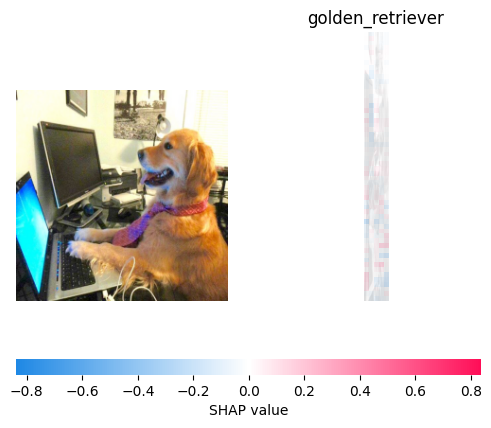

In [ ]:
# explain and visualize. If you're not using a powerful V100 GPU, this may take up to 20 minutes.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

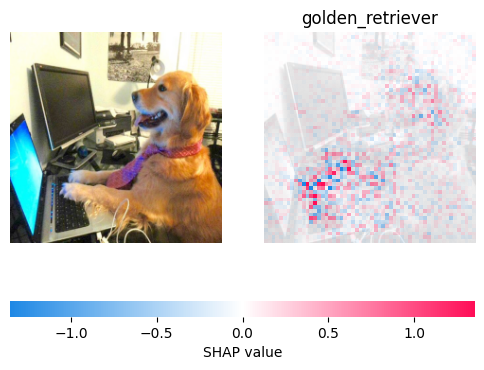

In [ ]:
shap.image_plot([shap_values[0].transpose(2, 1, 3, 0)], image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

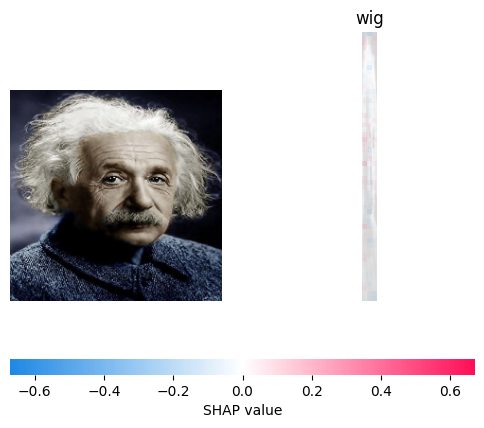

In [ ]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

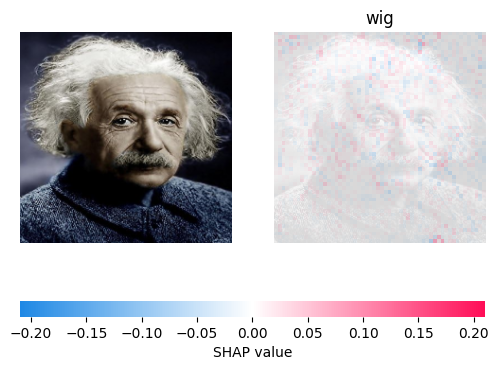

In [ ]:
shap.image_plot([shap_v.transpose(0, 1, 3, 2) for shap_v in shap_values], image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

In [ ]:
shap_values[0].shape